In [11]:
# Verified version

# Package Lab JuypterLab Notebook

This notebook is ued to show typical usage of the functions made for the TCLab board & PID regulation course.

## Import

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from ipywidgets import interact,FloatSlider # use of slider and interactive plot update

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import *
from package_LAB import *

## Lead Lag

In [13]:
help(Lead_Lag_RT)

Help on function Lead_Lag_RT in module package_LAB:

Lead_Lag_RT(MV, Kp, Tlead, Tlag, Ts, PV, PVInit=0, method='EBD')
    The function "Lead-lag_RT" needs to be included in a "for or while loop".
    
    :MV: input vector
    :Kp: process gain
    
    :Tlead: lead time constant [s]
    :Tlag: lag time constant [s]
    
    :Ts: sampling period [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretisation method (optional: default value is 'EBD')
        EBD: Euler Backward difference
        EFD: Euler Forward difference
        TRAP: Trapezoïdal method
    
    The function "Lead-lag_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretisation method.



In [14]:
Ts = 0.1
TSim = 100
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 0, 5: 1,50:2, 80:3,  TSim: 3}

def update_plot(Kp, Tlead, Tlag, theta): # clear old values
    t = []
    MV = []
    MVDelay = []
    PV_EBD = []
    PV_EFD = []
    PV_TRAP = []

    for i in range(0,N):
        t.append(i*Ts)
        SelectPath_RT(MVPath,t,MV)
        Delay_RT(MV,theta,Ts,MVDelay)

        Lead_Lag_RT(MVDelay, Kp, Tlead, Tlag, Ts, PV_EBD, PVInit=0, method='EBD')

    plt.figure(figsize = (15,9))

    # First subplot for MV and PV with delay
    plt.subplot(2,1,1)
    plt.step(t,MV,'b-',label='MV',where='post')
    plt.step(t,MVDelay,'b-',linewidth=0.5,label='MV plus delay',where='post')
    plt.ylabel('Value')
    plt.title('First order plus delay response')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    # Second subplot for PV with first-order response and delay
    plt.subplot(2,1,2)
    plt.step(t,PV_EBD,'g-',label='First order response plus delay (EBD)',where='post')
    plt.ylabel('Value')
    plt.xlabel('Time [s]')
    plt.legend(loc='best')
    plt.xlim([0, TSim])
    plt.show()

# Display interactive plot
interact(update_plot, 
         Kp=FloatSlider(min=0.1, max=3, step=0.1, value=1),
         Tlead=FloatSlider(min=-20, max=20, step=0.1, value=5),
         Tlag=FloatSlider(min=-20, max=40, step=0.1, value=3),
         theta=FloatSlider(min=0, max=20, step=0.1, value=1))

interactive(children=(FloatSlider(value=1.0, description='Kp', max=3.0, min=0.1), FloatSlider(value=5.0, descr…

<function __main__.update_plot(Kp, Tlead, Tlag, theta)>

## Process dynamics

In [15]:
#SOPDT PV in-out dynamics params
Kp = 0.46575892823243076
T1p = 132.04151002516983
T2p = 7.647730018039972
thetap = 0.0004910330468864688

#SOPDT DV disturbance dynamics params
Kd = 0.36816132905697
T1d = 128.19758463380253
T2d = 26.094509776696448
thetad = 2.000174864808916

## IMC

In [16]:
help(IMC_tuning)
Kc, Ti, Td = IMC_tuning(0.533, 19.38, 70.81, 14, 0.1, "SOPDT")
print(Kc, Ti, Td)

Help on function IMC_tuning in module package_LAB:

IMC_tuning(Kp, Tlag1=0, Tlag2=0, theta=0, gamma=0, process='FOPDT')
    The function "imc_tuning" is only for first and second order systems.
    :Kp: process gain
    :Tlag1: first (or main) lag time constant [s] used in your process
    :Tlag2: second lag time constant [s] used in your process
    :theta: delay [s] used in your process
    :gamma : constant used to get the closed loop time constant
    :process: process order (ex : FOPDT first order system wuth delay)
    :model: broida_simple or broida_complex for FOPDT
    :Tg:
    :Tu:
    :a:
    :t1: time for 28% of PV (100% being the steady state)
    :t2: time for 44% of PV
    :return: imc tuning parameters respectively:
    - Kc: controller gain
    - Ti: reset time
    - Td: derivative time
    The function "imc_tuning" returns the parameteres that you will use in your PID depending on your process parameters

10.616890921363435 90.19 15.215631444727798


## PID

In [17]:
help(PID_RT)

Help on function PID_RT in module package_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=0, method='EBD-EBD')
    Help on function PID_RT in module package_LAB:
    
    PID_RT (SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=@, method='EBD-EBD')
    The function "PID RT"
    needs to be included in a
    "for or while loop"
    
    SP: SP (or SetPoint) vector
    PV: PV (or Process Value) vector
    Man: Man (or Manual controller mode) vector (True or False)
    MVMan: MVMan (or Manual value for MV) vector
    MVFF: MVFF (or Feedforward) vector
    
    Kc: controller gain
    Ti: integral time constant [s]
    Td: derivative time constant [s]
    alpha: Tfd = alpha*Td where Tfd is the derivative filter time constant [s]
    Ts: sampling period [s]
    
    MVMin: minimum value for MV (used for saturation and anti wind-up)
    MVMax: maximum value for MV (us

In [18]:
TSim = 250
Ts = 0.01
N = int(TSim/Ts) + 1

T = 5
ActivateFF = True
ManFF= True

# Path for MV
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
PVPath = {0:50, 5:40, 50:40, 80:40, TSim: 40}
MVManPath = {0:50, 5:40, 50:40, 80:40, TSim: 40}
ManPath = {0: False, 0:False, 50:False, 80: True, 90 : False, TSim: False}
MVFFPath = {0:0, 200 : 15, TSim : True}

def update_pid(Kc, Ti, Td, alpha, theta, MVMin, MVMax):
    t = []
    SP = []
    PV = []
    E = []
    MVP=[]
    MVI=[]
    MVD=[]
    MV = []
    MVMan=[]
    Man = []
    MVFF = []

    for i in range(0,N):
        t.append(i*Ts)
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(PVPath,t,PV)
        SelectPath_RT(ManPath,t,Man)
        SelectPath_RT(MVManPath,t,MVMan)
        SelectPath_RT(MVFFPath,t,MVFF)
        PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,0)

    plt.figure(figsize = (15,9))

    plt.subplot(3,1,1) # MV, MV_P, MV_I, MV_D, MV_FF
    
    plt.step(t,MVP,'purple', linewidth=0.5,label='MVP',where='post')
    plt.step(t,MVI,'blue',label='MVI',where='post')
    plt.step(t,MVD,'green',label='MVD',where='post')
    #plt.step(t,SP,'blue',label='SP',where='post')
    #plt.step(t,PV,'c-',label='PV',where='post')
    plt.step(t,MV,'springgreen',linewidth=0.5,label='MV',where='post')
    plt.ylabel('Value of MV')
    plt.title('PID controller')
    plt.legend(loc="right")
    plt.xlim([0, TSim])

    plt.subplot(3,1,2)
    plt.title('Man plot')
    plt.step(t,E,'r-',label='E',where='post')
    plt.step(t,Man,'b-',label='Man',where='post')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    plt.subplot(3,1,3)
    plt.title('Man plot')
    plt.step(t,MVFF,'m-',label='MVFF',where='post')
    plt.legend(loc='best')
    plt.xlim([0, TSim])
    plt.show()

# Display interactive plot
interact(update_pid, 
         Kc=FloatSlider(min=0.1, max=10, step=0.1, value=5.5),
         Ti=FloatSlider(min=0.1, max=30, step=0.1, value=26.4),
         Td=FloatSlider(min=0.1, max=30, step=0.1, value=5.14),
         alpha=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.4),
         theta=FloatSlider(min=0.1, max=100, step=0.1, value=0.4),
         MVMin=FloatSlider(min=0.1, max=100, step=0.1, value=0),
         MVMax=FloatSlider(min=0.1, max=100, step=0.1, value=100),
         )

interactive(children=(FloatSlider(value=5.5, description='Kc', max=10.0, min=0.1), FloatSlider(value=26.4, des…

<function __main__.update_pid(Kc, Ti, Td, alpha, theta, MVMin, MVMax)>

# Margins

In [19]:
help(StabilityMargins)

Help on function StabilityMargins in module package_LAB:

StabilityMargins(P: package_DBR.Process, C: package_LAB.Controller, omega)
    The function "stability_margins" needs to have 2 processes object in paramaters.
    
    :P: the system process
    :C: the controller 
    :omega: frequency vector (rad/s); generated by a command of the type "omega = np.logspace(-2, 2, 10000)".
        
    The function "stability_margins" generates the bodes plots of the Loop gain and gives the phase and gain margins.



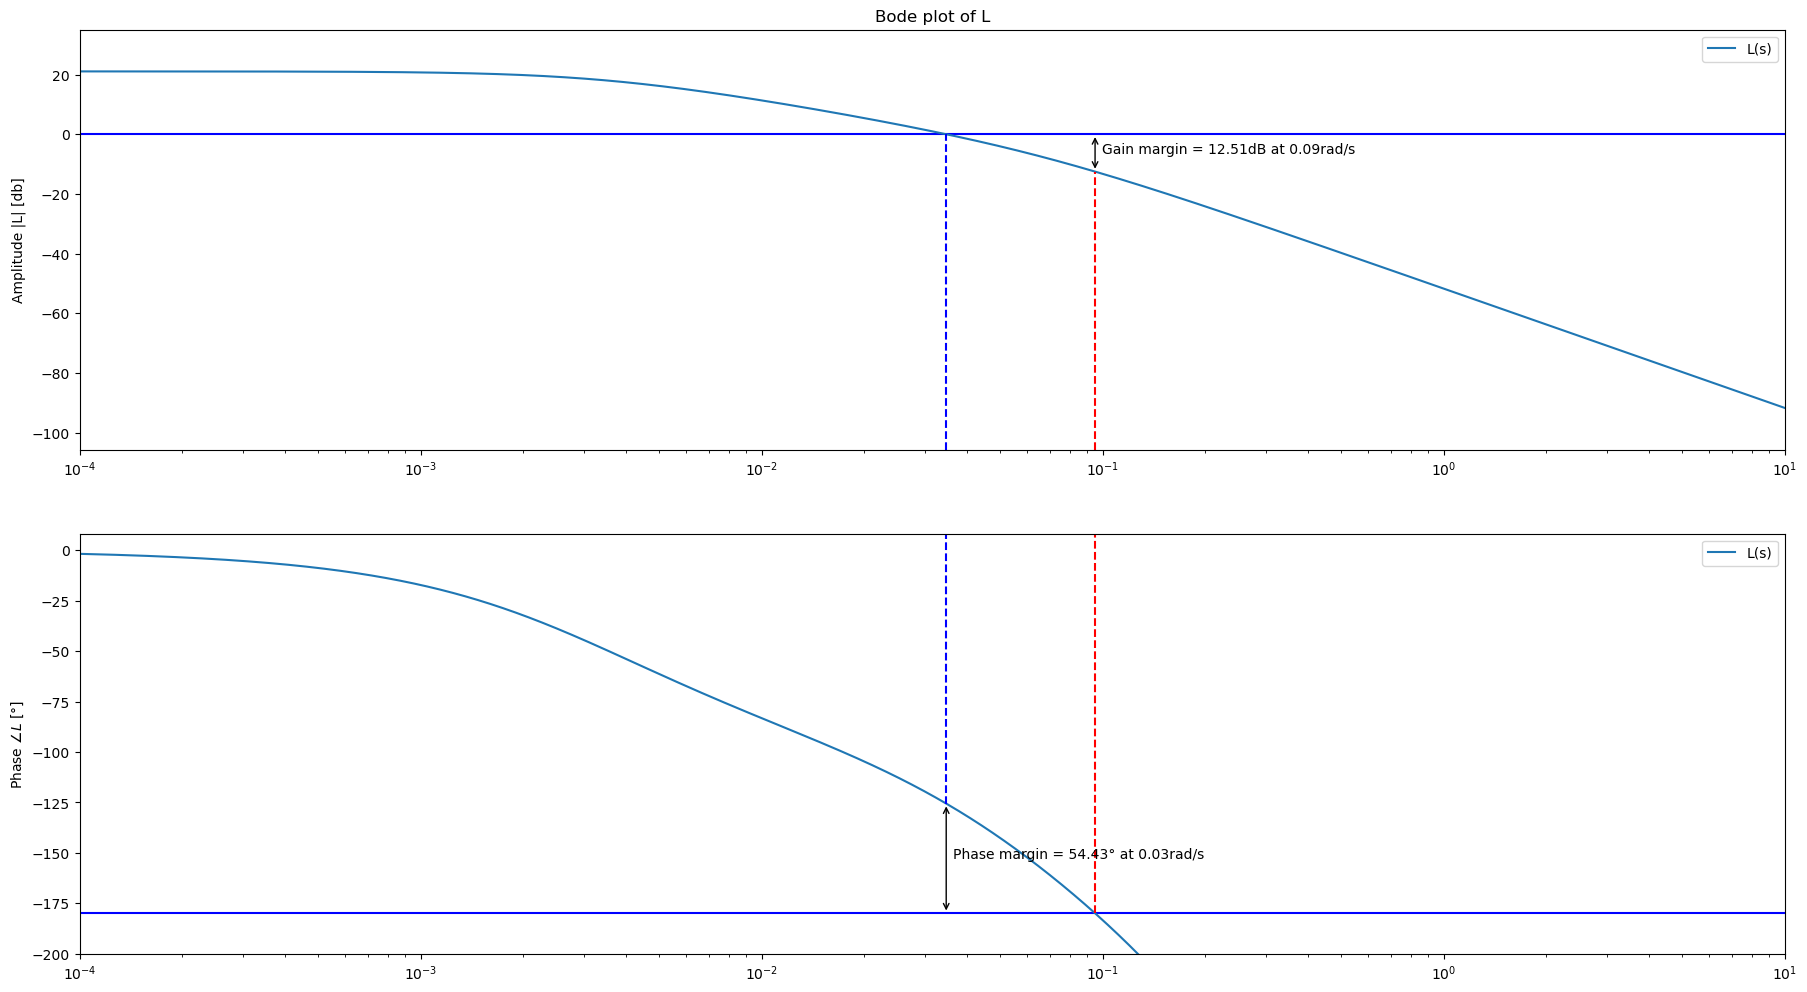

In [20]:
# IMC tuning values
C = Controller({})
C.parameters['Kc'] = 10.616890921363435
C.parameters['Ti'] = 90.19
C.parameters['Td'] = 15.215631444727798
C.parameters['alpha'] = 0.1

# python FOPDT values
P = Process({})
P.parameters['Kp']  = 0.6890796420174794
P.parameters['Tlag1'] = 195.93418960703713
P.parameters['theta'] = 6.661942351380765

omega = np.logspace(-4, 1, 10000)

StabilityMargins(P, C, omega)